In [24]:
import nidaqmx 
import numpy as np
import matplotlib.pyplot as plt
import visa
import time
from lantz import MessageBasedDriver, Q_
from lantz.core import Feat
from lantz.core import mfeats
    

def adquisicion(task,time,freq):
    dt = np.divide(1,freq)
    print(dt)
    time_vector = np.arange(0,time,dt)
    print(len(time_vector))
    num_of_points = len(time_vector)  
    data = task.read(number_of_samples_per_channel=num_of_points)
    print(len(data))
    return (time_vector,np.asarray(data))

ImportError: cannot import name 'nidaqmx' from 'nidaqmx' (C:\Users\usuario\Anaconda3\envs\Pruebas\lib\site-packages\nidaqmx\__init__.py)

AcquisitionType.FINITE
0.0002
500
500
5000.0


(0, 0.1)

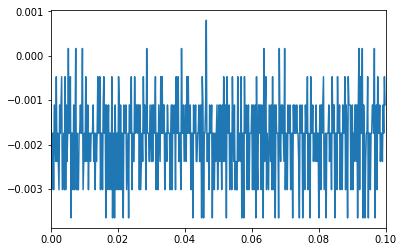

In [2]:
time = 0.1
freq = 5000
nsamples = 2000

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan('Dev1/ai0',
                                         terminal_config=nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL)
    task.timing.cfg_samp_clk_timing(freq,samps_per_chan=nsamples)
    print(task.timing.samp_quant_samp_mode)
    (tiempos,data) = adquisicion(task,time,freq)
#    task.write([1.1, 2.2, 3.3, 4.4, 5.5], auto_start=True)
    print(task.timing.samp_clk_rate)

plt.plot(tiempos,data)  
plt.xlim(0,0.1)    

In [2]:
class adquisicion_DAQ():#nidaqmx.Task,tipo='Analog'):
    def __init__(self,nidaqmx,mode = 'CONTINUOUS', mmode='DIFFERENTIAL',canal=0,tipo='Analog',sampleRate=48000):
        if tipo == 'Analog':
            # Por default se abre un canal en configuracion Differential
            
            if mmode == 'DIFFERENTIAL':
                defmmode = nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL
            elif mmode == 'RSE':
                 defmmode = nidaqmx.constants.TerminalConfiguration.RSE
            else:
                raise Exception('Wrong or not allowed connection mode')
                
            if mode == 'CONTINUOUS':
                defmode= nidaqmx.constants.AcquisitionType.CONTINUOUS   
            elif mode == 'FINITE':    
                defmode = nidaqmx.constants.AcquisitionType.FINITE   
            else:
                raise Exception('Wrong or not allowed measurement mode')
            self.smode = defmode
            self.freq = sampleRate            
            
            self.task = nidaqmx.Task()
            self.task.ai_channels.add_ai_voltage_chan('Dev1/ai'+str(canal),
                                             terminal_config=defmmode)     
            self.task.timing.cfg_samp_clk_timing(self.freq,sample_mode = self.smode, samps_per_chan=2*self.freq)
            
    @property
    def frequency(self):
        return self.task.timing.samp_clk_rate
    @frequency.setter
    def frequency(self,freq):
        # Se define una cantidad de samples de manera de poder medir 2 segundos en la frequencia definida
        self.task.timing.cfg_samp_clk_timing(freq,sample_mode = self.smode, samps_per_chan=np.floor(2*freq))
        
    @property
    def sampleMode(self):
        if str(self.task.timing.samp_quant_samp_mode) == 'AcquisitionType.FINITE':
            modesh = 'FINITE'
        elif str(self.task.timing.samp_quant_samp_mode) == 'AcquisitionType.CONTINUOUS':
             modesh = 'CONTINUOUS'  
        else:
             modesh= 'none'
        #print(task.timing.samp_quant_samp_mode)   
        return modesh 

    @sampleMode.setter
    def sampleMode(self,modo):
        # Se define una cantidad de samples de manera de poder medir 2 segundos en la frequencia definida
        if modo == 'CONTINUOUS':
            self.smode = nidaqmx.constants.AcquisitionType.CONTINUOUS
        elif modo == 'FINITE':
            self.smode = nidaqmx.constants.AcquisitionType.FINITE     
        else:
            pass
        self.task.timing.cfg_samp_clk_timing(self.freq,sample_mode = self.smode, samps_per_chan=np.floor(2*self.freq))

    def adquisicion(self,time):
        dt = np.divide(1,self.freq)
        time_vector = np.arange(0,time,dt)
        num_of_points = len(time_vector)  
        data = self.task.read(number_of_samples_per_channel=num_of_points)
        return (time_vector,np.asarray(data))

        
class Generador(MessageBasedDriver):
    # Feats punciona como un property, pero ademas acepta otras opciones
    @Feat()
    def idn(self):
        return self.query('*IDN?')

    # La idea es no usar sets and gets como metodos, sino definir propiedades
    def setFrequency(self,freq):
        self.write("SOURce1:FREQuency:FIXed "+str(freq))
        
    # Una manera comoda de unas Feats es con mfeats, donde directametne pasas el getter, el setter, las unidades y un limite para los valroes
    amplitude = mfeats.QuantityFeat('SOURce1:VOLT:LEV:IMM:AMPL?','SOURce1:VOLT:LEV:IMM:AMPL {}',units='V',limits=(0.2,5))
        
    def setWaveform(self,waveform ='Senoidal'):
        switcher = {'Senoidal':"SIN",'Cuadrada':"SQU",'Pulso':"PULS"}
        self.write("SOURce1:FUNCtion "+switcher.get(waveform,'Senoidal'))  

In [4]:
prueba=adquisicion_DAQ(nidaqmx,tipo='Analog')

In [31]:
time = 0.1
freq = 5000
nsamples = 2000

#prueba.frequency=freq
print(prueba.sampleMode)
t,data=prueba.adquisicion(time)
plt.plot(t,data)

CONTINUOUS


DaqError: The specified resource is reserved. The operation could not be completed as specified.
Task Name: _unnamedTask<6>

Status Code: -50103

In [48]:
type(np.floor(2*freq))

numpy.float64

In [53]:
nidaqmx.constants.AcquisitionType

<enum 'AcquisitionType'>

¿Qué cosas quiero que haga la daq?
Enviar señales analógicas
Enviar señales digitales
Adquirir señales digitales
Adquirir señales analógicas

¿Qué parámetros quiero setear en cada envío o medición y cuáles quiero setear de manera general?

En cada medición:
- \# de muestras
- valor
- tiempo

En general:

- sample rate
- aquisition mode
- channel


In [5]:
time = 0.1
freq = 5000
nsamples = 2000

#prueba.timebase=freq


with prueba:
    print(prueba.sampleMode)
    t,data=prueba.adquisicion(time)
    plt.plot(t,data)

AttributeError: __enter__

In [35]:
prueba.close()

AttributeError: 'adquisicion_DAQ' object has no attribute 'close'

In [50]:
class adquisicion_DAQ(nidaqmx.constants,nidaqmx.Task()):#nidaqmx.Task,tipo='Analog'):
                  
    @property
    def add_channel(self,canal):
         
        self.freq=48000
        self.ai_channels.add_ai_voltage_chan('Dev1/ai'+str(canal),
                                         terminal_config=nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL)     
        self.timing.cfg_samp_clk_timing(self.freq,sample_mode = nidaqmx.constants.AcquisitionType.CONTINUOUS, samps_per_chan=2*self.freq)
        
    @property
    def frequency(self):
        return self.task.timing.samp_clk_rate
    @frequency.setter
    def frequency(self,freq):
        # Se define una cantidad de samples de manera de poder medir 2 segundos en la frequencia definida
        self.task.timing.cfg_samp_clk_timing(freq,sample_mode = self.smode, samps_per_chan=np.floor(2*freq))        

TypeError: metaclass conflict: the metaclass of a derived class must be a (non-strict) subclass of the metaclasses of all its bases

In [43]:
with adquisicion_DAQ(nidaqmx.Task()) as daq1:
    pass

AttributeError: 'Task' object has no attribute 'constants'

In [22]:
nidaqmx.ClassName

AttributeError: module 'nidaqmx' has no attribute 'ClassName'

SyntaxError: invalid syntax (<ipython-input-36-6889a3496bcb>, line 1)

In [38]:
import pyvisa
type(pyvisa.resources.usb.USBInstrument)

type

module

In [52]:
(V,i,j) = np.loadtxt('C:/Users/usuario/Documents/GitHub/Instrumentacion_y_control/Informe_1/Datos/Tension_vs_corriente_led.txt')

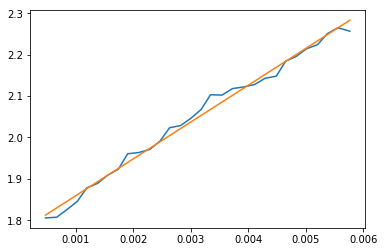

In [78]:
x=i[10:40]
y=V[10:40]
plt.plot(x,y)
plt.plot(x,m*x+b,'-')

In [69]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x, y)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

ModuleNotFoundError: No module named 'sklearn'

In [72]:
m = np.divide(len(x) * np.sum(x*y) - np.sum(x) * np.sum(y),len(x)*np.sum(x*x) - np.sum(x) ** 2)
b = np.divide(np.sum(y) - m *np.sum(x), len(x) )   

In [73]:
print(m)

88.88712544017605


In [83]:
rm = visa.ResourceManager()

In [84]:
ID=rm.list_resources()

In [85]:
ID

()